### MSEplots functions --- adding ensembles of entrainment and detrainment, internal-gravity  waves
--keyword arguments for the ensemble size, and h0 range <br>
fixed: "h4ent = mse" would replace mse as doing h4ent += h0offset, rewriting this part 

(12/05/2018)<br>
--adding s,h,hs overlay, entrainment xaxis <br>
--adding temperature dependence of latent heat Lv and Lice <br>
--adding Z array as an input for "g*z" correction <br> 
--setting axes for detrainment bars, fixed limitation <br>

(01/11/2019) <br>
--defining the first EL for detrainment histogram rather than EL_max to avoid "missing" histogarms on special conditions 

(02/04/2019) <br>
--adding entropy keyword: Raymond and Blyth, 1992 <br>
(Raymond 2013, Sources and sinks of entropy in the atmosphere
 Schubert et al., 2018 Heat and Moisture Budget Analysis with an Improved Form of Moist Thermodynamics: They have different equations for defined entropy, resulting wierd values. Need to be verified someday...)  

(02/06/2019) <br>
--remove P_top=200mbar in CWV calculation due to nan issues in some cases

(02/18/2019)<br>
adding entropy_plots function

(03/20/2019)<br>
checking entroy values in upper levels

(05/16/2019)<br>
adding the ice phase, entrainment methods and buoyancy profiles. Functions from [here](https://github.com/weiming9115/ATM663_convection_meso/blob/master/Resources/Notebooks/Real_Parcel_Buoyancy_weiming.ipynb)

(10/18/2019)<br>
adding indices output function (cape,cin,LCL,LFC,CWV,EL)

<br>
Last Date: 10/18/2019

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

import metpy.calc as mpcalc
from metpy.units import units
from metpy.constants import Cp_d,Cp_v,Lv,Rd,g,Rv,Cv_d,Cv_v

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin() # find minimum
    return (idx)

In [3]:
def esat(T):
# Saturation vapor pressure IN HPA as a function of temperature IN CELSIUS
    if( np.max(np.abs(T)) > 100 ) :
        print, 'esat: Please provide T in CELSIUS ', np.max(np.abs(T))
        #return 0

# This one is from Emanuel page 116 (4.4.13), over liquid at all temperatures
    Tref = 273.15
    ESAT = np.exp( 53.67957 - 6743.769/(T+Tref) - 4.8451*np.log(T+Tref) )

    # Water only  
    return ESAT 

def esati(T):
# Saturation vapor pressure IN HPA as a function of temperature IN CELSIUS
    if( np.max(np.abs(T)) > 100 ) :
        print, 'esat: Please provide T in CELSIUS ', np.max(np.abs(T))
        return 0

    # This one is from Emanuel page 116 (4.4.13), over liquid at all temperatures
    Tref = 273.15
    ESAT = np.exp( 53.67957 - 6743.769/(T+Tref) - 4.8451*np.log(T+Tref) )
    # This one is over ice, but valid at subzero temperatures only
    ESATI = np.exp( 23.33086 - 6111.72784/(T+Tref) + 0.15215*np.log(T+Tref) )

    # Stitch them together into the optput array based on sign of T in C    
    return np.where(T>0, ESAT,ESATI)

def mixrat(Td,p):
# Td in C# p in mb
    if( np.max(np.abs(Td)) > 100 or np.max(np.abs(p)) > 1050) :
        print, 'mixrat: provide Td in C, p in mb',np.max(np.abs(Td)),np.max(np.abs(p))
        #return 0

    # simple formula with 0.622 rato of molecular weight or R vapor vs. air    
    es = esat(Td)
    return 0.622 * es / (p-es)

def Tv(T,qv): 
    Tref = 273.16
    return (1 + 0.61*qv)*(T+Tref) - Tref # virtual temperature

def Trho(T,qv,qc): 
    Tref = 273.16
    return (1 + 0.61*qv -qc)*(T+Tref) - Tref # density temperature, considering condensed water loading

def entropy(T,qtot,p): 
# T in degC, p in mb, qtot in kg/kg
    if( np.max(T) > 100. or np.max(np.abs(p)) > 1050. or np.max(np.abs(qtot)) > 0.1 ):
        print( 'entropy: provide T in centigrade, p in mb, qtot in kg/kg') 
        print( T,p,qtot )
        return 0

    # from Raymond & Blyth 1992
    Tref = 273.15 
    pref = 1000.0
    Cpd = 1005.		# dry air heat capacity at const p
    Cpv = 1850.		# water vapor heat capacity at const p
    Rv = 461.51		# Gas constant for vapor
    Rd = 287.05		# Gas constant for dry air
    Lref = 2.501e6 		# vaporization heat at Tref
    Cl  =  4218.		# liquid water heat capacity
    eref = 6.106		# sat p at Tref (mb)

    L = Lref - (Cl - Cpv)*T		# T ARRAY IN CENTIGRADE

    qsat = mixrat(T,p)
    qv = np.where(qtot < qsat, qtot, qsat)
    e = esat(T) *qv/qsat

    s = (Cpd + qtot*Cl)*np.log( (T+Tref)/Tref ) - Rd*np.log( (p-e)/pref ) + \
        L*qv/(T+Tref) - qv*Rv*np.log(qv/qsat)

    return s

def invert_entropy(sm,qt,p):
# Inverts entropy sm & total water qt at pressures p (mb) 
# Returns T & qv vapor mixing ratio
# Met units: mb, C, kg/kg 

    LOOPMAX =  200 #  /* max number of iteration loops */

    #/* invert the entropy equation -- use Newton's method. Measure ds for dT=1K

    ts = 200.0 + p/10. - 273.16	 # crude first guess (C)    
    for i in range(0, LOOPMAX+1):
        fs0 = entropy(ts,p,qt) - sm
        fs1 = entropy(ts - 1.,p,qt) - sm
        dts = fs0/(fs1 - fs0) # dT/ds * (entropy error of guess ts)
        ts  = ts+dts          # correct that guess, linearized way
        
        #print('loop iteration i',i,'largest error is:', np.max(np.abs(dts)))

        if (np.max(np.abs(dts)) < .01): break # this will end the loop 
        if (i == LOOPMAX - 1):
            print( "s invert not converging" )
            return 0
                
# gather up result and return it
    T = ts   # latest guess from iteration
    qvsat = mixrat(T,p)		#/* saturation mixing ratio at computed temp */
    qv = np.where(qt < qvsat,qt, qvsat)      #/* check for saturation */

    return T,qv 

def MSE(T,Z,qv): # units C, m, kg/kg
    Cp = 1005.		# dry air heat capacity at const p
    L = 2.501e6 		# vaporization heat at Tref
    g = 9.8 
    Tref = 273.16
    
    return Cp*(T+Tref) + g*Z + L*qv

def invert_MSE(h,qt,Z,p):
# Inverts h value & total water qt at a set of heights Z (in m) and pressures p (in mb)
# Returns T & qv vapor mixing ratio of parcel
# Met units: m, C, kg/kg, mb

#/* invert the transitive MSE equation -- use Newton's method
    LOOPMAX =  400 #  /* max number of iteration loops */

    ts = h*0 +20 -6*Z/1000. # crude first guess at T (6 K/km lapse rate)

# Now iterate
    for i in range(0, LOOPMAX+1):
        
    # The MSE profile based on guess ts and min(qt,qvsat)
        qsat0 = mixrat(ts, p)
        qv0 = np.where(qt<qsat0,qt, qsat0)
        MSE0 = MSE(ts,   Z, qv0      ) 

    # now MSE profile for a +1K perturbation
        qsat1 = mixrat(ts+1, p)
        qv1 = np.where(qt<qsat1,qt, qsat1)
        MSE1 = MSE(ts+1,Z, qv1) 
        
    # So we can estimate the derivative dMSE/dT
        dMSEdT = MSE1-MSE0      # J/kg per K 
        
    # Use that derivative to estimate the correction to the guess ts
        dts = (h-MSE0)/dMSEdT # convert MSE error of first guess ts to K units
        ts  = ts+dts          # correct initial T guess using that slope
            
    # test if correction is small, and quit if so. Otherwise, repeat. 
        if (np.max(np.abs(dts)) < .01): break # end loop 
        if (i == LOOPMAX - 1) :
            print( "MSE invert not converging" )
            #return 0
                
    # After the corrections have converged, gather up result and return it
    qvsat = mixrat(ts,p)		#/* saturation mixing ratio at computed temp */
    qv = np.where(qt < qvsat,qt, qvsat)      #/* check for saturation */

    return ts,qv 

In [4]:
def thermo_plots(pressure,temperature,mixing_ratio):
    """"
    plots for vertical profiles of temperature, dewpoint, mixing ratio and relative humidity.
    
    Parameters
    ----------
    pressure : array-like
            Atmospheric pressure profile (surface to TOA)
    temperature: array-like
            Atmospheric temperature profile (surface to TOA)
    dewpoint: array-like
            Atmospheric dewpoint profile (surface to TOA)    
    Returns
    -------
    """
    p = pressure*units('mbar')
    q = mixing_ratio*units('kilogram/kilogram')
    T = temperature*units('degC')
    
    Td = mpcalc.dewpoint_from_specific_humidity(q,T,p) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]) # parcel
    
    plt.figure(figsize = (12,5))
    
    lev = find_nearest(p.magnitude,100);
    plt.subplot(1,3,1)
    plt.plot(T[:lev],p[:lev],'-ob')
    plt.plot(Td[:lev],p[:lev],'-og')
    plt.plot(Tp[:lev],p[:lev],'-or')
    plt.xlabel('Temperature [C]',fontsize=12)
    plt.ylabel('Pressure [hpa]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(['Temp','Temp_Dew','Temp_Parcel'],loc=1)
    plt.grid()
    
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    # Relative humidity
    RH = q/qs*100 # Relative humidity

    plt.subplot(1,3,2)
    plt.plot(q[:lev],p[:lev],'-og')
    plt.xlabel('Mixing ratio [kg/kg]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(RH[:lev],p[:lev],'-og')
    plt.xlabel('Relative humiduty [%]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid()
    
    plt.tight_layout()
    return (plt)

def theta_plots(pressure,temperature,mixing_ratio):
    """
    plots for vertical profiles of potential temperature, equivalent potential temperature, 
    and saturated equivalent potential temperature
    """
    p = pressure*units('mbar')
    T = temperature*units('degC')
    q = mixing_ratio*units('kilogram/kilogram')
    
    lev = find_nearest(p.magnitude,100)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    theta = mpcalc.potential_temperature(p,T)
    theta_e = mpcalc.equivalent_potential_temperature(p,T,Td)
    theta_es = mpcalc.equivalent_potential_temperature(p,T,T)
       
    plt.figure(figsize=(7,7))
    plt.plot(theta[:lev],p[:lev],'-ok')
    plt.plot(theta_e[:lev],p[:lev],'-ob')
    plt.plot(theta_es[:lev],p[:lev],'-or')
    plt.xlabel('Temperature [K]',fontsize=12)
    plt.ylabel('Pressure [hpa]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(['$\\theta$','$\\theta_e$','$\\theta_{es}$'],loc=1)
    plt.grid()
    return (plt)

def msed_plots(pressure,temperature,mixing_ratio,altitude,h0_std=2000,ensemble_size=20,ent_rate=np.arange(0,2,0.05),
               entrain=False):
    """
    plotting the summarized static energy diagram with annotations and thermodynamic parameters
    """
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC') # parcel profile
    
    # Altitude based on the hydrostatic eq.
    if len(altitude) == len(pressure): # (1) altitudes for whole levels
        altitude = altitude*units('meter')
    elif len(altitude) == 1: # (2) known altitude where the soundings was launched
        z_surf = altitude.copy()*units('meter'); # given altitude
        altitude = np.zeros((np.size(T)))*units('meter') 
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) + z_surf # Hypsometric Eq. for height
    else: 
        print('***NOTE***: the altitude at the surface is assumed 0 meter, and altitudes are derived based on the hypsometric equation')
        altitude = np.zeros((np.size(T)))*units('meter') # surface is 0 meter
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) # Hypsometric Eq. for height
            
    # Static energy calculations   
    mse = mpcalc.moist_static_energy(altitude,T,q)
    mse_s = mpcalc.moist_static_energy(altitude,T,qs)
    dse = mpcalc.dry_static_energy(altitude,T)

    # Water vapor calculations
    p_PWtop = min(p)
    #p_PWtop = max(200*units.mbar, min(p) + 1*units.mbar) # integrating until 200mb 
    cwv = mpcalc.precipitable_water(Td,p,top=p_PWtop) # column water vapor [mm]
    cwvs = mpcalc.precipitable_water(T,p,top=p_PWtop) # saturated column water vapor [mm]
    crh = (cwv/cwvs)*100. # column relative humidity [%]

    #================================================
    # plotting MSE vertical profiles
    fig = plt.figure(figsize=[12,8])
    ax = fig.add_axes([0.1,0.1,0.6,0.8])
    ax.plot(dse,p,'-k',linewidth=2)
    ax.plot(mse,p,'-b',linewidth=2)
    ax.plot(mse_s,p,'-r',linewidth=2)
    
    # mse based on different percentages of relative humidity
    qr = np.zeros((9,np.size(qs)))*units('kilogram/kilogram'); mse_r = qr*units('joule/kilogram')# container
    for i in range(9):
        qr[i,:] = qs*0.1*(i+1)
        mse_r[i,:] = mpcalc.moist_static_energy(altitude,T,qr[i,:])

    for i in range(9):
        ax.plot(mse_r[i,:],p[:],'-',color='grey',linewidth=0.7)
        ax.text(mse_r[i,3].magnitude/1000-1,p[3].magnitude,str((i+1)*10))
                
    # drawing LCL and LFC levels
    [lcl_pressure, lcl_temperature] = mpcalc.lcl(p[0], T[0], Td[0])
    lcl_idx = np.argmin(np.abs(p.magnitude - lcl_pressure.magnitude))
    
    [lfc_pressure, lfc_temperature] = mpcalc.lfc(p,T,Td)
    lfc_idx = np.argmin(np.abs(p.magnitude - lfc_pressure.magnitude))
    
    # conserved mse of air parcel arising from 1000 hpa    
    mse_p = np.squeeze(np.ones((1,np.size(T)))*mse[0].magnitude)
    
    # illustration of CAPE
    el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
    el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))
    ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
    
    [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])

    ax.plot(mse_p,p,'g',linewidth=1.5)
    ax.fill_betweenx(p[lcl_idx:el_idx+1],mse_p[lcl_idx:el_idx+1],mse_s[lcl_idx:el_idx+1],interpolate=True
                    ,color='green',alpha='0.3')

    ax.fill_betweenx(p,dse,mse,color='deepskyblue',alpha='0.5')
    ax.set_xlabel('Specific static energies: s, h, hs [kJ kg$^{-1}$]',fontsize=14)
    ax.set_ylabel('Pressure [hPa]',fontsize=14)
    ax.set_xticks([280,300,320,340,360,380])
    ax.set_xlim([280,390])
    ax.set_ylim(1030,120)
    
    if entrain is True:
    # Depict Entraining parcels
    # Parcel mass solves dM/dz = eps*M, solution is M = exp(eps*Z)
    # M=1 at ground without loss of generality
            
    # Distribution of surface parcel h offsets
        h0offsets = np.sort(np.random.normal(0, h0_std, ensemble_size))*units('joule/kilogram')
        # Distribution of entrainment rates 
        entrainment_rates = ent_rate /(units('km'))
        
        for h0offset in h0offsets:
            
            h4ent = mse.copy(); h4ent[0] += h0offset;
            
            for eps in entrainment_rates: 
                                
                hent = h4ent.copy()
                delz = np.gradient(altitude)*units('meter')
                                
                for iz in range(1,len(altitude[1:])):
                    hent[iz] = hent[iz-1] + eps*delz[iz-1]*( mse[iz-1]-hent[iz-1] )                                    
                
                # Boolean for positive buoyancy, and its topmost altitude (index) where curve is clippes
                posboy  = (hent > mse_s); posboy[0] = True  # so there is always a detrainment level
                
                # defining the first EL by posboy as the detrainment layer, switching from positive buoyancy to
                # negative buoyancy (0 to 1) and skipping the surface
                ELindex_ent = 0
                for idx in range(len(posboy)-1):
                    if posboy[idx+1] == 0 and posboy[idx] == 1 and idx > 0: 
                        ELindex_ent = idx;break
                        
                # Plot the curve        
                plt.plot( hent[0:ELindex_ent+2], p[0:ELindex_ent+2], linewidth=0.6, color='g')
                #plt.plot( hent[0:], p[0:], linewidth=0.6, color='g')
                # Keep a list for a histogram plot (detrainment profile)  
                if p[ELindex_ent].magnitude < lfc_pressure.magnitude: # buoyant parcels only
                    ELps.append( p[ELindex_ent].magnitude )
                
        # Plot a crude histogram of parcel detrainment levels
        NBINS = 20
        pbins = np.linspace(1000,150,num=NBINS) # pbins for detrainment levels
        hist = np.zeros((len(pbins)-1))
        for x in ELps:
            for i in range(len(pbins)-1):
                if (x < pbins[i]) & (x >= pbins[i+1]):
                    hist[i] += 1;break
                    
        det_per = hist/sum(hist)*100; # percentages of detrainment ensumbles at levels
        
        ax2 = fig.add_axes([0.705,0.1,0.1,0.8],facecolor=None)
        ax2.barh( pbins[1:], det_per, color='lightgrey',edgecolor='k',height=15*(20/NBINS))
        ax2.set_xlim([0,100])
        ax2.set_xticks([0,20,40,60,80,100])
        ax2.set_ylim([1030,120])
        ax2.set_xlabel('Detrainment [%]')
        ax2.grid()
        ax2.set_zorder(2)

        ax.plot( [400,400], [1100,0])
        ax.annotate('Detrainment', xy=(362,320), color='dimgrey')
        ax.annotate('ensemble: ' + str(ensemble_size*len(entrainment_rates)), xy=(364, 340), color='dimgrey')
        ax.annotate('Detrainment', xy=(362,380), color='dimgrey')
        ax.annotate(' scale: 0 - 2 km', xy=(365,400), color='dimgrey')
    
        # Overplots on the mess: undilute parcel and CAPE, etc. 
        ax.plot( (1,1)*mse[0], (1,0)*(p[0]), color='g',linewidth=2)

        # Replot the sounding on top of all that mess
        ax.plot(mse_s , p, color='r', linewidth=1.5) 
        ax.plot(mse , p, color='b', linewidth=1.5) 

        # label LCL and LCF
        ax.plot((mse_s[lcl_idx]+(-2000,2000)*units('joule/kilogram')), lcl_pressure+(0,0)*units('mbar') ,color='orange',linewidth=3)
        ax.plot((mse_s[lfc_idx]+(-2000,2000)*units('joule/kilogram')), lfc_pressure+(0,0)*units('mbar') , color='magenta',linewidth=3)
  
    
    ### Internal waves (100m adiabatic displacements, assumed adiabatic: conserves s, sv, h). 
    #dZ = 100 *mpunits.units.meter
    dp = 1000*units.pascal
    
    # depict displacements at sounding levels nearest these target levels
    targetlevels = [900,800,700,600,500,400,300,200]*units.hPa
    for ilev in targetlevels:
        idx = np.argmin(np.abs(p - ilev))

        # dp: hydrostatic
        rho = (p[idx])/Rd/(T[idx])
        dZ = -dp/rho/g

        # dT: Dry lapse rate dT/dz_dry is -g/Cp
        dT = (-g/Cp_d *dZ).to('kelvin')    
        Tdisp = T[idx].to('kelvin') + dT

        # dhsat
        dqs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Tdisp) ,p[idx]+dp) - qs[idx]
        dhs = g*dZ + Cp_d*dT + Lv*dqs

        # Whiskers on the data plots
        ax.plot( (mse_s[idx]+dhs*(-1,1)), p[idx]+dp*(-1,1), linewidth=3, color='r')  
        ax.plot( (dse[idx]    *( 1,1)), p[idx]+dp*(-1,1), linewidth=3, color='k')  
        ax.plot( (mse[idx]    *( 1,1)), p[idx]+dp*(-1,1), linewidth=3, color='b')  

        # annotation to explain it 
        if ilev == 400*ilev.units:
            ax.plot(360*mse_s.units +dhs*(-1,1)/1000, 440*units('mbar')
                     +dp*(-1,1), linewidth=3, color='r')  
            ax.annotate('+/- 10mb', xy=(362,440), fontsize=8)
            ax.annotate(' adiabatic displacement', xy=(362,460), fontsize=8)
    
    # Plot a crude histogram of parcel detrainment levels
    # Text parts
    ax.text(290,pressure[3],'RH (%)',fontsize=11,color='k')
    ax.text(285,200,'CAPE = '+str(np.around(CAPE.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    ax.text(285,250,'CIN = '+str(np.around(CIN.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    ax.text(285,300,'LCL = '+str(np.around(lcl_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='darkorange')
    ax.text(285,350,'LFC = '+str(np.around(lfc_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='magenta')
    ax.text(285,400,'CWV = '+str(np.around(cwv.magnitude,decimals=2))+' [mm]',fontsize=12,color='deepskyblue')
    ax.text(285,450,'CRH = '+str(np.around(crh.magnitude,decimals=2))+' [%]',fontsize=12,color='blue')
    ax.legend(['DSE','MSE','SMSE'],fontsize=12,loc=1)
    
    ax.set_zorder(3)
    
    return (ax)

def add_curves_Wyoming(ax,datetime,station,linewidth=1.0,LH_Tdepend=False):
    """
    overlaying new curves of multiple soundings from Wyoming datasets
    date: using datetime module. ex. datetime(2018,06,06) 
    station: station name. ex. 'MFL' Miami, Florida
    """
    from siphon.simplewebservice.wyoming import WyomingUpperAir

    date = datetime
    station = station
    df = WyomingUpperAir.request_data(date, station)
    pressure = df['pressure'].values
    Temp = df['temperature'].values
    Temp_dew = df['dewpoint'].values
    altitude = df['height'].values
    q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Temp_dew*units('degC')),pressure*units('mbar'))
    q = mpcalc.specific_humidity_from_mixing_ratio(q)
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Temp*units('degC')),pressure*units('mbar'))
    
    # specific energies
    if LH_Tdepend == False:
        mse = mpcalc.moist_static_energy(altitude*units('meter'),Temp*units('degC'),q)
        mse_s = mpcalc.moist_static_energy(altitude*units('meter'),Temp*units('degC'),qs)
        dse = mpcalc.dry_static_energy(altitude*units('meter'),Temp*units('degC'))
    else:
        # A short course in cloud physics, Roger and Yau (1989)
        Lvt = (2500.8 - 2.36*T.magnitude + 0.0016*T.magnitude**2 - 
              0.00006*T.magnitude**3)*units('joule/gram') # latent heat of evaporation
        #Lf = 2834.1 - 0.29*T - 0.004*T**2                  # latent heat of fusion
        
        mse = Cp_d*T + g*altitude + Lvt*q
        mse_s = Cp_d*T + g*altitude + Lvt*qs
        dse = mpcalc.dry_static_energy(altitude,T)
        
    # adding curves on the main axes
    ax.plot(dse.magnitude, pressure, 'k', linewidth=linewidth)
    ax.plot(mse.magnitude, pressure, 'b', linewidth=linewidth)
    ax.plot(mse_s.magnitude, pressure, 'r', linewidth=linewidth)

def add_curves(ax,pressure,temperature,mixing_ratio,altitude,linewidth=1.0,LH_Tdepend=False):
    """
    overlaying new curves of multiple soundings from profiles
    """
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC') # parcel profile

    # Altitude based on the hydrostatic eq.
    if len(altitude) == len(pressure): # (1) altitudes for whole levels
        altitude = altitude*units('meter')
    elif len(altitude) == 1: # (2) known altitude where the soundings was launched
        z_surf = altitude.copy()*units('meter'); # given altitude
        altitude = np.zeros((np.size(T)))*units('meter') 
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) + z_surf # Hypsometric Eq. for height
    else: 
        print('***NOTE***: the altitude at the surface is assumed 0 meter, and altitudes are derived based on the hypsometric equation')
        altitude = np.zeros((np.size(T)))*units('meter') # surface is 0 meter
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) # Hypsometric Eq. for height
    
    # specific energies 
    if LH_Tdepend == False:
        mse = mpcalc.moist_static_energy(altitude,T,q)
        mse_s = mpcalc.moist_static_energy(altitude,T,qs)
        dse = mpcalc.dry_static_energy(altitude,T)
    else:
        # A short course in cloud physics, Roger and Yau (1989)
        Lvt = (2500.8 - 2.36*T.magnitude + 0.0016*T.magnitude**2 - 
              0.00006*T.magnitude**3)*units('joule/gram') # latent heat of evaporation
        #Lf = 2834.1 - 0.29*T - 0.004*T**2                  # latent heat of fusion
        
        mse = Cp_d*T + g*altitude + Lvt*q
        mse_s = Cp_d*T + g*altitude + Lvt*qs
        dse = mpcalc.dry_static_energy(altitude,T)
        
    ax.plot(dse, p, '--k', linewidth=linewidth)
    ax.plot(mse, p, '--b', linewidth=linewidth)
    ax.plot(mse_s, p, '--r', linewidth=linewidth)

def add_RCEREF(ax,cooling=-1.3,heatflux=116):
    ### Energy is area, draw reference boxes. 
    RCEloc = 260
    ax.set_xlim([250,390])

    ax.plot([RCEloc,RCEloc],[0,1100], linewidth=0.5) ### thin reference line
    ax.annotate('daily RCE', xy=(RCEloc,1045), horizontalalignment='center')

    #### Radiative cooling reference
    ax.fill([RCEloc  , RCEloc -1.3, RCEloc -1.3, RCEloc, RCEloc ],             
            [1000 , 1000    , 200     , 200, 1000],             
            linewidth=1, color='c', alpha=0.9)

    ax.annotate(' cooling'+ str(cooling) + '$K/d$',  xy=(RCEloc-5, 300), color='c')

    #### Surface flux reference
    ax.fill([RCEloc  , RCEloc +11, RCEloc +11, RCEloc, RCEloc ],             
            [1000 , 1000   , 910    , 910, 1000],             
            linewidth=1, color='orange', alpha=0.5)

    ax.annotate(' heat flux', xy=(RCEloc,890), color='orange')
    ax.annotate(str(heatflux) + '$W m^{-2}$', xy=(RCEloc,940))

def add_entropy(ax,pressure,temperature,mixing_ratio,ds=100,linewidth=1.0):
    "add entropy curves and rescale values to fit in by 0.5*entropy + ds"
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC') # parcel profile

    # specific entropy [joule/(kg*K)]
    # sd : specific entropy of dry air
    # sm1 : specific entropy of airborne mositure in state 1 (water vapor)
    # sm2 : specific entropy of airborne mositure in state 2 (saturated water vapor)
    
    sd = entropy(T,q*0,p)
    sm1 = entropy(T,q,p)
    sm2 = entropy(T,qs,p)

    ax.plot(sd.magnitude*0.5+ds,p,'--k')
    ax.plot(sm1.magnitude*0.5+ds,p,'--b')
    ax.plot(sm2.magnitude*0.5+ds,p,'--r')

def entropy_plots(pressure,temperature,mixing_ratio,altitude,h0_std=2000,ensemble_size=20,ent_rate=np.arange(0,2,0.05),entrain=False):
    """
    plotting the summarized entropy diagram with annotations and thermodynamic parameters
    """
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC') # parcel profile
    
    # Altitude based on the hydrostatic eq.
    if len(altitude) == len(pressure): # (1) altitudes for whole levels
        altitude = altitude*units('meter')
    elif len(altitude) == 1: # (2) known altitude where the soundings was launched
        z_surf = altitude.copy()*units('meter'); # given altitude
        altitude = np.zeros((np.size(T)))*units('meter') 
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) + z_surf # Hypsometric Eq. for height
    else: 
        print('***NOTE***: the altitude at the surface is assumed 0 meter, and altitudes are derived based on the hypsometric equation')
        altitude = np.zeros((np.size(T)))*units('meter') # surface is 0 meter
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) # Hypsometric Eq. for height
   
    # specific entropy [joule/(kg*K)]
    # sd : specific entropy of dry air
    # sm1 : specific entropy of airborne mositure in state 1 (water vapor)
    # sm2 : specific entropy of airborne mositure in state 2 (saturated water vapor)
    
    sd = entropy(T.magnitude,q.magnitude*1e-6,p.magnitude) 
    sm1 = entropy(T.magnitude,q.magnitude,p.magnitude)  
    sm2 = entropy(T.magnitude,qs.magnitude,p.magnitude) 
    ###############################
    
    # Water vapor calculations
    p_PWtop = min(p)
    #p_PWtop = max(200*units.mbar, min(p) + 1*units.mbar) # integrating until 200mb 
    cwv = mpcalc.precipitable_water(Td,p,top=p_PWtop) # column water vapor [mm]
    cwvs = mpcalc.precipitable_water(T,p,top=p_PWtop) # saturated column water vapor [mm]
    crh = (cwv/cwvs)*100. # column relative humidity [%]

    #================================================
    # plotting MSE vertical profiles
    fig = plt.figure(figsize=[12,8])
    ax = fig.add_axes([0.1,0.1,0.6,0.8])
    ax.plot(sd,p,'-k',linewidth=2)
    ax.plot(sm1,p,'-b',linewidth=2)
    ax.plot(sm2,p,'-r',linewidth=2)
    
    # mse based on different percentages of relative humidity
    qr = np.zeros((9,np.size(qs)))*units('kilogram/kilogram'); sm1_r = qr # container
    for i in range(9):
        qr[i,:] = qs*0.1*(i+1)
        sm1_r[i,:] = entropy(T.magnitude,qr[i,:].magnitude,p.magnitude)

    for i in range(9):
        ax.plot(sm1_r[i,:],p[:],'-',color='grey',linewidth=0.7)
        ax.text(sm1_r[i,3].magnitude-2,p[3].magnitude,str((i+1)*10))
                
    # drawing LCL and LFC levels
    [lcl_pressure, lcl_temperature] = mpcalc.lcl(p[0], T[0], Td[0])
    lcl_idx = np.argmin(np.abs(p.magnitude - lcl_pressure.magnitude))
    
    [lfc_pressure, lfc_temperature] = mpcalc.lfc(p,T,Td)
    lfc_idx = np.argmin(np.abs(p.magnitude - lfc_pressure.magnitude))
    
    # conserved mse of air parcel arising from 1000 hpa    
    sm1_p = np.squeeze(np.ones((1,np.size(T)))*sm1[0])
    
    # illustration of CAPE
    el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
    el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))
    ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
    
    [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])
    
    plt.plot(sm1_p,p,color='green',linewidth=2)
    #ax.fill_betweenx(p[lcl_idx:el_idx+1],sm1_p[lcl_idx:el_idx+1],sm2[lcl_idx:el_idx+1],interpolate=True
    #                ,color='green',alpha='0.3')

    ax.fill_betweenx(p,sd,sm1,color='deepskyblue',alpha='0.5')
    ax.set_xlabel('Specific entropy: sd, sm, sm_sat [J K$^{-1}$ kg$^{-1}$]',fontsize=14)
    ax.set_ylabel('Pressure [hPa]',fontsize=14)
    ax.set_xticks([0,50,100,150,200,250,300,350])
    ax.set_xlim([0,440])
    ax.set_ylim(1030,120)
    
    if entrain is True:
    # Depict Entraining parcels
    # Parcel mass solves dM/dz = eps*M, solution is M = exp(eps*Z)
    # M=1 at ground without loss of generality
            
    # Distribution of surface parcel h offsets
        h0offsets = np.sort(np.random.normal(0, h0_std, ensemble_size))*units('joule/kilogram')
        # Distribution of entrainment rates 
        entrainment_rates = ent_rate /(units('km'))
        
        for h0offset in h0offsets:
            
            h4ent = sm1.copy(); h4ent[0] += h0offset;
            
            for eps in entrainment_rates: 
                
                M = np.exp(eps * (altitude-altitude[0])).to('dimensionless')
                # dM is the mass contribution at each level, with 1 at the origin level. 
                M[0] = 0
                dM = np.gradient(M)
                # parcel mass is a sum of all the dM's at each level
                # conserved linearly-mixed variables like h are weighted averages
                if eps.magnitude == 0.0:
                    hent = np.ones(len(h4ent))*h4ent[0] # no mixing 
                else:
                    hent = np.cumsum(dM*h4ent) / np.cumsum(dM)
                # Boolean for positive buoyancy, and its topmost altitude (index) where curve is clippes
                posboy  = (hent > sm2); posboy[0] = True  # so there is always a detrainment level
                
                # defining the first EL by posboy as the detrainment layer, swiching from positive buoyancy to
                # negative buoyancy (0 to 1) and skipping the surface
                ELindex_ent = 0
                for idx in range(len(posboy)-1):
                    if posboy[idx+1] == 0 and posboy[idx] == 1 and idx > 0: 
                        ELindex_ent = idx;break
                        
                # Plot the curve        
                plt.plot( hent[0:ELindex_ent+2], p[0:ELindex_ent+2], linewidth=0.6, color='g')
                #plt.plot( hent[0:], p[0:], linewidth=0.6, color='g')
                # Keep a list for a histogram plot (detrainment profile)  
                if p[ELindex_ent].magnitude < lfc_pressure.magnitude: # buoyant parcels only
                    ELps.append( p[ELindex_ent].magnitude )
                
        # Plot a crude histogram of parcel detrainment levels
        NBINS = 20
        pbins = np.linspace(1000,150,num=NBINS) # pbins for detrainment levels
        hist = np.zeros((len(pbins)-1))
        for x in ELps:
            for i in range(len(pbins)-1):
                if (x < pbins[i]) & (x >= pbins[i+1]):
                    hist[i] += 1;break
                    
        det_per = hist/sum(hist)*100; # percentages of detrainment ensumbles at levels
        
        ax2 = fig.add_axes([0.705,0.1,0.1,0.8],facecolor=None)
        ax2.barh( pbins[1:], det_per, color='lightgrey',edgecolor='k',height=15*(20/NBINS))
        ax2.set_xlim([0,100])
        ax2.set_xticks([0,20,40,60,80,100])
        ax2.set_ylim([1030,120])
        ax2.set_xlabel('Detrainment [%]')
        ax2.grid()
        ax2.set_zorder(2)

        ax.plot( [400,400], [1100,0])
        ax.annotate('Detrainment', xy=(362,320), color='dimgrey')
        ax.annotate('ensemble: ' + str(ensemble_size*len(entrainment_rates)), xy=(364, 340), color='dimgrey')
        ax.annotate('Detrainment', xy=(362,380), color='dimgrey')
        ax.annotate(' scale: 0 - 2 km', xy=(365,400), color='dimgrey')
    
        # Overplots on the mess: undilute parcel and CAPE, etc. 
        ax.plot( (1,1)*sm1[0], (1,0)*(p[0]), color='g',linewidth=2)

        # Replot the sounding on top of all that mess
        ax.plot(sm2 , p, color='r', linewidth=1.5) 
        ax.plot(sm1 , p, color='b', linewidth=1.5) 

        # label LCL and LCF
        ax.plot((sm2[lcl_idx]+(-2000,2000)*units('joule/kilogram')), lcl_pressure+(0,0)*units('mbar') ,color='orange',linewidth=3)
        ax.plot((sm2[lfc_idx]+(-2000,2000)*units('joule/kilogram')), lfc_pressure+(0,0)*units('mbar') , color='magenta',linewidth=3)
    
    # Plot a crude histogram of parcel detrainment levels
    # Text parts
    ax.text(30,pressure[3],'RH (%)',fontsize=11,color='k')
    ax.text(20,200,'CAPE = '+str(np.around(CAPE.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    ax.text(20,250,'CIN = '+str(np.around(CIN.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    ax.text(20,300,'LCL = '+str(np.around(lcl_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='darkorange')
    ax.text(20,350,'LFC = '+str(np.around(lfc_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='magenta')
    ax.text(20,400,'CWV = '+str(np.around(cwv.magnitude,decimals=2))+' [mm]',fontsize=12,color='deepskyblue')
    ax.text(20,450,'CRH = '+str(np.around(crh.magnitude,decimals=2))+' [%]',fontsize=12,color='blue')
    ax.legend(['DEnt','MEnt','SMEnt'],fontsize=12,loc=1)
    
    ax.set_zorder(3)
    
    return (ax)

### Entrainment assumptions and buoyancy profiles

In [5]:
# esati, mixrat
def mixrat_i(T,p):
    es = esati(T)
    return 0.622*es/(p-es)

def delT4ice(TpMSE,p,qcpMSE,qvpMSE,Tf=0,simple=True):
# computes delta T, an increase in temperature due to latent heat of freezing and the deposition 
# of water vapor on ice (Iribarne and Godson, 1981 eq.94)
    Tref = 273.15 # reference Temp.
    Ls = 2.83e6 # J/kg, latent heat of sublimation
    Lf = 3.34e5 # J/kg, latent heat of freezing
    Cpd = 1005  # J/kg
    Cpv = 1996  # J/kg
    Cpi = 2108  # J/kg
    Rv = 461.51 # J/K/kg
    
    if simple == True:
        
        delT = Lf*qcpMSE/Cpd
        Tdev = TpMSE + delT
        
        Tdev = np.where(TpMSE < Tf, Tdev, TpMSE)
        qcpdev = np.where(TpMSE < Tf, 0, qcpMSE) # 100% convert to ice phase below zero deg
        qipdev = np.where(TpMSE < Tf, qcpMSE, 0) # 100% convert to ice phase below zero deg
        return Tdev,qcpdev,qipdev
        
    else: # precise calculation based on Iribarne and Godson (1981)
        LOOPMAX = 200 # iteration number
    
        fg0 = -8*np.ones(len(Tp))   # first guess
        k = np.zeros(len(Tp))
    
        for i in range(0, LOOPMAX+1):
                
            rs = qcp + mixrat(Tp,p) - mixrat_i(fg0,p)
            Cpt = Cpd + mixrat(Tp,p)*Cpv + rs*Cpi       
            a = ( Lf*qcp + Ls*qvp*(1-esati(Tp)/esat(Tp)) )
            b = (Cpt + mixrat_i(fg0,p)*Ls**2/(Rv*(Tp+Tref)**2))
            delT = a / b
        
            print(len(delT))
            if np.max(np.abs(delT-k)) < 1e-2:
                break
                fg0 = Tf + delT
        
            else:
                k = delT
                fg0 = Tf + delT
            
            Tdev = np.where(Tp < Tf, fg0, Tp)
        
            return Tdev

In [6]:
def entrain_const(p,c=1e-3):
    dp = -np.append(0,np.diff(p))
    X = c
    X = np.where(p > 950,0.18,X) # In the PBL, X = 0.18 hPa^-1
    return X*dp

def entrain_coeffA(Z,p,ce=0.4):
# calculate entrainment coefficient from depp inflow mixing A
    dz = np.append(0,np.diff(Z))
    dp = -np.append(0,np.diff(p))
    X = ce*dz/Z/dp
    X[0] = 0 
    return X*dp

def entrain_coeffB(p):
# calculate entrainment coefficient from deep inflow mixing B

    # specify a vertical profile of m that increases linearly at lower levels:
    # m=0 at surface and m reaches to the maximum at 430hPa, no entrainment above
    ps = p[0]
    b = np.pi/2/(1-430/ps); a = -b/ps
    m = np.sin( a*p + b ) # specified vertical profile of mass flux 
    
    #dmdp = np.gradient(m,p)
    dmdp = np.append(0,np.diff(m))/np.append(0,np.diff(p))
    dp = -np.append(0,np.diff(p))
    X = -dmdp/m
        
    X = np.where(p > 950, 1/(ps-p),X)
    X = np.where(p > 430, X, 0) # no entrainment above 430 hPa
    X[0] = 0 # at surface, denominator is zero
    
    return X*dp, m

def entrain_dyn(h,T,q,Z,p,Xmin=1e-3,Z0=350,W0=10):
# entrainment coeff for interactive/dynamic entrainment rate
# considering the dependence of buoyancy/vertical velocity
    Rd = 287.15
    Z0 = Z0 # meter
    W0 = W0 # m/s
    ps = p[0]
    
    TpMSE,qvpMSE = invert_MSE(h[0],q[0], np.where(Z<18000.,Z,18000.), np.where(p>100.,p,100.))
    qcpMSE = q[0]-qvpMSE
    b = 9.8*(Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q))/(Tv(T,q)+273.15) # buoyancy 
    
    # diagnosis of vertical velocity
    W2 = np.zeros(len(Z))
    dz = np.append(0,np.diff(Z))
    for k in range(len(Z)):
        B = np.trapz(b[:k+1]*Z[:k+1],Z[:k+1])
        W2[k] = B/Z[k] + W0**2*((Z[k]/Z0)**-1)
    
    W = W2**(1/2) # vertical velocity [m/s]
        
    # convert W into omega: omega = -ro*g*w
    ro = p/(Rd*(Tv(TpMSE,qvpMSE)+273.15))*100
    omega = -ro*9.8*W
    
    X = W2.copy()
    dp = -np.append(0,np.diff(p))
    for k in range(1,len(p)):
        X[k] = Xmin + (omega[k]-omega[k-1])/(dp[k]*(omega[k]+omega[k-1])/2)
    
    X[X<0] = 0 # avoid negative entrainment [not documented implicitly in Sahany et al., 2012]
    X = np.where(p > 950, 1/(ps-p),X)
    X[0] = 0

    return X*dp, omega, B, W2

def conserved_dmix(s,q,X):
# calculate entrained conserved variable over the whole levels
# where sp is conserved variable of parcel, s is environmental value,
# and X is entrainment coefficient.
        
    s_mix = np.zeros(len(s)); q_mix = s_mix.copy()
    s_mix[0] = s[0]; q_mix[0] = q[0] # total water content
    for z in range(1,len(s)):
        s_mix[z] = (1-X[z-1])*s_mix[z-1] + X[z-1]*s[z-1]
        q_mix[z] = (1-X[z-1])*q_mix[z-1] + X[z-1]*q[z-1]
        
    return s_mix, q_mix

In [7]:
def entrainment_plot(hp_mix,X_mix,s,h,hs,p):
    'plot MSE and mixing coefficient profiles of a entrainment assumption'
    'hp_mix: MSE after mixing'
    'X_mix: mixing coefficient [hPa^-1]'
    's,h,hs: dry, moist, saturated moist static energy'
        
    fig = plt.figure(figsize=(14,5))

    ax1 = plt.subplot(1,2,1)
    # mixing curves
    ax1.plot(hp_mix/1000,p,'m',zorder=2) 
    ax1.plot(h*0+h[0]/1000,p,'grey',zorder=2, label='_nolegend_') # undiluted parcel
    plt.xlabel('Specific static energy [kJ/kg]',fontsize=12);plt.ylabel('[hPa]',fontsize=12)
    plt.xlim([300,360]); plt.ylim([1020,100])

    ax1.plot(s/1000, p, 'k', label='_nolegend_')
    ax1.plot(h/1000,p,'royalblue', label='_nolegend_')
    ax1.plot(hs/1000, p, 'darkblue', label='_nolegend_')

    dp = -np.gradient(p)
    ax2 = plt.subplot(1,2,2)
    ax2.plot(X_mix/dp,p,'m',zorder=2)
    plt.xlabel('Mixing coeff X [hPa$^{-1}$]',fontsize=12);plt.ylabel('[hPa]',fontsize=12)
    plt.ylim([1020,100]);plt.xlim([0,0.02]) 

    return ax1, ax2

In [55]:
def indices_output(pressure,temperature,mixing_ratio,altitude):
    p  = pressure*units('mbar')
    T  = temperature*units('degC')
    q  = mixing_ratio*units('kilogram/kilogram')
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q)) # dewpoint 
    Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC') # parcel profile
    
    # Altitude based on the hydrostatic eq.
    if len(altitude) == len(pressure): # (1) altitudes for whole levels
        altitude = altitude*units('meter')
    elif len(altitude) == 1: # (2) known altitude where the soundings was launched
        z_surf = altitude.copy()*units('meter'); # given altitude
        altitude = np.zeros((np.size(T)))*units('meter') 
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) + z_surf # Hypsometric Eq. for height
    else: 
        print('***NOTE***: the altitude at the surface is assumed 0 meter, and altitudes are derived based on the hypsometric equation')
        altitude = np.zeros((np.size(T)))*units('meter') # surface is 0 meter
        for i in range(np.size(T)):
            altitude[i] = mpcalc.thickness_hydrostatic(p[:i+1],T[:i+1]) # Hypsometric Eq. for height
            
    # Static energy calculations   
    mse = mpcalc.moist_static_energy(altitude,T,q)
    mse_s = mpcalc.moist_static_energy(altitude,T,qs)
    dse = mpcalc.dry_static_energy(altitude,T)

    # Water vapor calculations
    p_PWtop = min(p)
    #p_PWtop = max(200*units.mbar, min(p) + 1*units.mbar) # integrating until 200mb 
    cwv = mpcalc.precipitable_water(Td,p,top=p_PWtop) # column water vapor [mm]
    cwvs = mpcalc.precipitable_water(T,p,top=p_PWtop) # saturated column water vapor [mm]
    crh = (cwv/cwvs)*100. # column relative humidity [%]

    # drawing LCL and LFC levels
    [lcl_pressure, lcl_temperature] = mpcalc.lcl(p[0], T[0], Td[0])
    lcl_idx = np.argmin(np.abs(p.magnitude - lcl_pressure.magnitude))
    
    [lfc_pressure, lfc_temperature] = mpcalc.lfc(p,T,Td)
    lfc_idx = np.argmin(np.abs(p.magnitude - lfc_pressure.magnitude))
    
    # conserved mse of air parcel arising from 1000 hpa    
    mse_p = np.squeeze(np.ones((1,np.size(T)))*mse[0].magnitude)
    
    # illustration of CAPE
    el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
    el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))
    ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
    
    [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])
    
    # dataframe output
    d = {'Precipitable_water': [np.around(cwv,3)],'Column_relative_humidity': [np.around(crh,3)],
         'CAPE': [np.around(CAPE,3)], 'CIN': [-np.around(CIN,3)], 
         'LCL': [np.around(lcl_pressure,3)],'LFC': [np.around(lfc_pressure,3)], 'EL': [np.around(el_pressure,3)]}
    df = pd.DataFrame(data=d)
    
    return df

### MSE_Analysis User's Interface 
#### 1. import modules and sounding data

In [46]:
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.calc.thermo import *
from metpy.units import units
from metpy.plots import add_metpy_logo, SkewT
from scipy.interpolate import interp1d

# reading data prociding vertical profiles of T, Td, pressure and height
date = datetime(2018, 8, 22, 0)
station = 'MFL'

df = WyomingUpperAir.request_data(date, station)
pp = df['pressure'].values #hPa
TT = df['temperature'].values  #C
Tdd = df['dewpoint'].values #C
ZZ = df['height'].values   #m
rr = mixing_ratio( saturation_vapor_pressure(Tdd*units('degC')), pp*units('hPa') ) 
qq = specific_humidity_from_mixing_ratio(rr).magnitude

# ----- for entrainment algorithms, coarse vertical resolutions -----
# linear interpoaltion into pressure levels
p = np.linspace(pp[0],pp[-1],200) # 200 pressure levels
# interpolated variables T, Td, Z
f = interp1d(pp,TT); T = f(p)
f = interp1d(pp,Tdd); Td = f(p)
f = interp1d(pp,ZZ); Z = f(p)

r = mixing_ratio( saturation_vapor_pressure(Td*units('degC')), p*units('hPa') ) 
q = specific_humidity_from_mixing_ratio(r).magnitude
rs = mixing_ratio( saturation_vapor_pressure(T*units('degC')), p*units('hPa') ) 
qs = specific_humidity_from_mixing_ratio(rs).magnitude

In [56]:
df = indices_output(pp,TT,qq,ZZ)
df 

,Precipitable_water,Column_relative_humidity,CAPE,CIN,LCL,LFC,EL
0,40.167 millimeter,51.477 dimensionless,1252.47 joule / kilogram,51.349 joule / kilogram,876.641 millibar,753.962 millibar,167.728 millibar


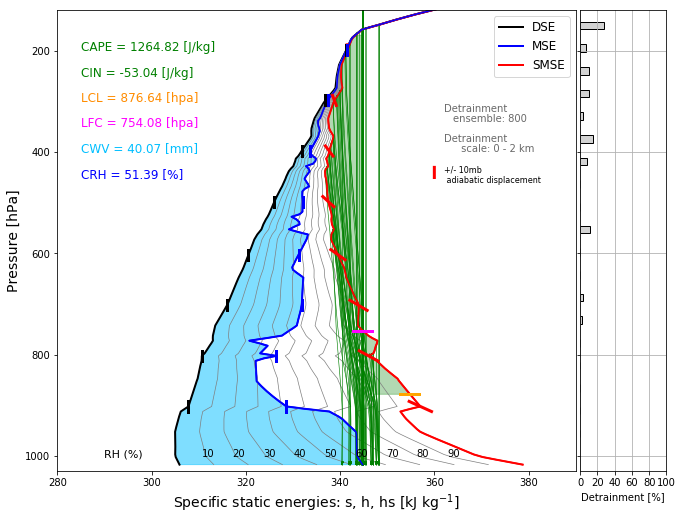

In [10]:
ax = msed_plots(p,T,q,Z,ent_rate=np.arange(0,2,0.05),entrain=True) # altitude included
#ax.set_title('Wyoming Upper Air, 20190418, 00Z, MFL',fontsize=15)

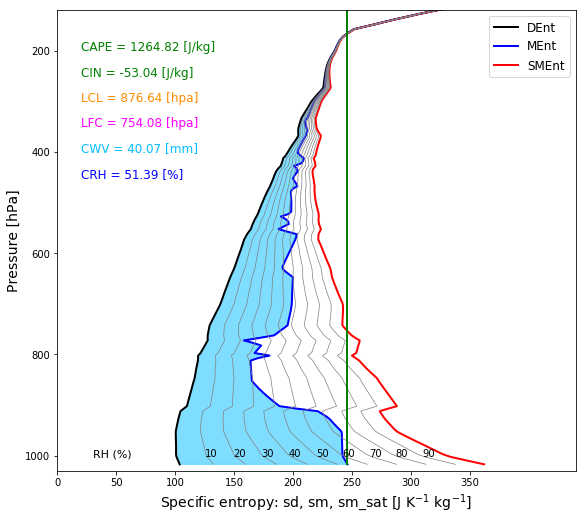

In [10]:
ax = entropy_plots(p,T,q,Z,ent_rate=np.arange(0,2,0.05),entrain=False)

#### 2. Applying entrainment methods for the current sounding

In [11]:
# calculate mixing coefficients for each method
s = MSE(T,Z,q*1e-9) #/1000*units.units('kJ/kg')
h = MSE(T,Z,q)      #/1000*units.units('kJ/kg')
hs = MSE(T,Z,qs)    #/1000*units.units('kJ/kg')

X_c1 = entrain_const(p,c=1e-3)
hp_c1, qp_c1 = conserved_dmix(h,q,X_c1)

X_A = entrain_coeffA(Z,p,ce=0.4)
hp_mixA, qp_mixA = conserved_dmix(h,q,X_A)

X_B, m = entrain_coeffB(p)
hp_mixB, qp_mixB = conserved_dmix(h,q,X_B)

X_dyn, omega_diag, B_diag, b = entrain_dyn(h,T,q,Z,p,Xmin=1e-3)
hp_mixdyn, qp_mixdyn = conserved_dmix(h,q,X_dyn)

MSE invert not converging


/Users/willytsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/willytsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/willytsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/Users/willytsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in sqrt
/Users/willytsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less
/Users/willytsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide


/Users/willytsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/Users/willytsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/willytsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


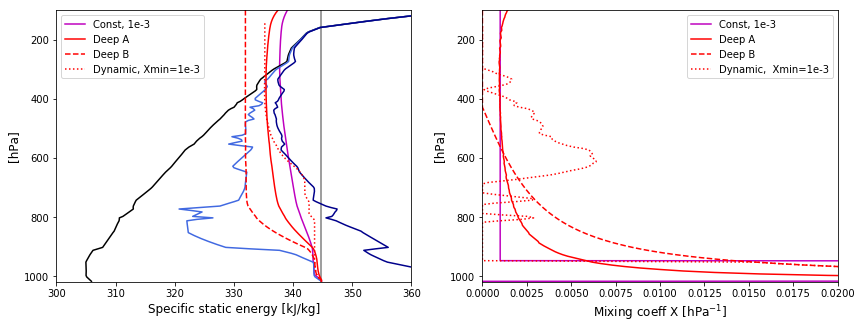

In [12]:
ax1, ax2 = entrainment_plot(hp_c1,X_c1,h,p)

# add results of different assumptions
ax1.plot(hp_mixA/1000,p,'r')
ax1.plot(hp_mixB/1000,p,'--r')
ax1.plot(hp_mixdyn/1000,p,':r')

ax1.legend(['Const, 1e-3','Deep A','Deep B','Dynamic, Xmin=1e-3'])

# adding results of different assumptions
dp = -np.append(0,np.diff(p))
ax2.plot(X_A/dp,p,'r')
ax2.plot(X_B/dp,p,'--r')
ax2.plot(X_dyn/dp,p,':r')
ax2.legend(['Const, 1e-3','Deep A','Deep B','Dynamic,  Xmin=1e-3'])